## C4T1

This script is intended to demonstrate some of the methods one can use to transform sparse input time series data. Source data set is from the UCI machine learning repository, found here: https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption

In [1]:
# dependency checking
dependencies <- c("dplyr", "caret", "xts")
staged <- dependencies[!(dependencies %in% installed.packages()[,"Package"])]
if(length(staged)) install.packages(staged, 
                                    repos = c("http://rstudio.org/_packages", 
                                              "http://cran.rstudio.com"))
dependencies <- NULL
staged <- NULL

In [2]:
# imports (needs caret import in future version)
suppressMessages(library(dplyr, xts))
sessionInfo(c("zoo","xts"))


R version 3.3.2 (2016-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.2 LTS

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
character(0)

other attached packages:
[1] zoo_1.7-13 xts_0.9-7 

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.8     grDevices_3.3.2 digest_0.6.10   crayon_1.3.2   
 [5] dplyr_0.5.0     assertthat_0.1  IRdisplay_0.4.4 repr_0.10      
 [9] R6_2.2.0        jsonlite_1.1    DBI_0.5-1       magrittr_1.5   
[13] evaluate_0.10   datasets_3.3.2  stringi_1.1.5   utils_3.3.2    
[17] uuid_0.1-2      graphics_3.3.2  IRkernel_0.7.1  base_3.3.2     
[21] tools_3.3.2     stringr_1.1.0   stats_3.3.2     pbd

In [3]:
# globals
dataUrl = paste("http://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip")

In [4]:
# read data set from internets
temp <- tempfile()
download.file(dataUrl, temp)
data <- read.table(
          unz(
            temp,
            "household_power_consumption.txt"
          ),
          sep=";",
          header=TRUE
        )

In [5]:
# view the raw data and create a backup df (just in case)
head(data,5)
dataBak <- data

Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17
16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16
16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17
16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17
16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17


In [27]:
# load the backup data (only run if you dun screwed up)
data <- dataBak

In [13]:
# lets keep an eye on our memory footprint...
sort( sapply(ls(),function(x){object.size(get(x))})) 

dependencies       staged         temp      dataUrl         data      dataBak 
           0            0          136          216     83644688     83644688

In [28]:
# create dateTime column
data <- cbind(
      data,paste(data$Date,data$Time), 
      stringsAsFactors=FALSE)
colnames(data)[10] <-"dateTime"

In [29]:
# move dateTime col to col1 of table
data <- data[,c(ncol(data), 1:(ncol(data)-1))]

In [30]:
# remove the old date and time cols
data <- data[,-c(2:3)]

In [31]:
# convert data types
data$Global_active_power <- as.numeric(as.character(data$Global_active_power))
data$Global_reactive_power <- as.numeric(as.character(data$Global_reactive_power))
data$Voltage <- as.numeric(as.character(data$Voltage))
data$Global_intensity <- as.numeric(as.character(data$Global_intensity))
data$Sub_metering_1 <- as.numeric(as.character(data$Sub_metering_1))
data$Sub_metering_2 <- as.numeric(as.character(data$Sub_metering_2))

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

In [32]:
# get count of rows in data frame
print(
        c(
        'Rows before NA removal: ', 
            prettyNum(
                nrow(data),big.mark=",",scientific=FALSE
            )
        )
)

[1] "Rows before NA removal: " "2,075,259"               


In [33]:
# get count of NA rows in data frame, by column
data.frame(sapply(data, function(y) sum(length(which(is.na(y))))))

,sapply.data..function.y..sum.length.which.is.na.y.....
dateTime,0
Global_active_power,25979
Global_reactive_power,25979
Voltage,25979
Global_intensity,25979
Sub_metering_1,25979
Sub_metering_2,25979
Sub_metering_3,25979


In [34]:
# remove NAs and view count of rows after NA removal
data <- na.omit(data)
print(
        c(
        'Rows after NA removal: ', 
            prettyNum(
                nrow(data),big.mark=",",scientific=FALSE
            )
        )
)

[1] "Rows after NA removal: " "2,049,280"              


In [35]:
# view the cleaned data
head(data,2)

dateTime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
16/12/2006 17:24:00,4.216,0.418,234.84,18.4,0,1,17
16/12/2006 17:25:00,5.360,0.436,233.63,23.0,0,1,16


In [41]:
# convert dateTime from chr to POSIXlt object and display POSIXlt format and data type
data$dateTime <- strptime(
  data[,1],
  format="%d/%m/%Y %H:%M:%S",
  tz=""
)
head(data$dateTime[1])
class(data[1:100,1])

[1] "2006-12-16 17:24:00 GMT"

# Begin experimentation with xts and POSIX dates

In [53]:
# would be great to feed this into xts, but doesn't want to take cols 2:4 w/ chr errors...
data[1:10,c("dateTime","Sub_metering_1","Sub_metering_2","Sub_metering_3")]

dateTime,Sub_metering_1,Sub_metering_2,Sub_metering_3
2006-12-16 17:24:00,0,1,17
2006-12-16 17:25:00,0,1,16
2006-12-16 17:26:00,0,2,17
2006-12-16 17:27:00,0,1,17
2006-12-16 17:28:00,0,1,17
2006-12-16 17:29:00,0,2,17
2006-12-16 17:30:00,0,1,17
2006-12-16 17:31:00,0,1,17
2006-12-16 17:32:00,0,1,17
2006-12-16 17:33:00,0,2,16


In [63]:
# create an xts object (eXtensible time series); takes POSIXlt input vector
# note that library must be called explicitly, not sure why...
xtsObj <- xts::as.xts(data[1:10000,1])
xtsObj

Data:
numeric(0)

Index:
 POSIXlt[1:10000], format: "2006-12-16 17:24:00" "2006-12-16 17:25:00" ...

In [64]:
xts::first(xtsObj,'1 week')

Data:
numeric(0)

Index:
 POSIXlt[1:10000], format: "2006-12-16 17:24:00" "2006-12-16 17:25:00" ...

# Begin 'conventional' study with non-POSIX ts() objects...

In [65]:
# create year / month / day features
data$year <- as.factor(strftime(data[,1], format="%Y"))
data$month <- as.factor(strftime(data[,1], format="%b"))
data$dayOfMonth <- as.factor(strftime(data[,1], format="%e"))
data$hour <- as.factor(strftime(data[,1], format="%k"))

In [66]:
# create a new dataframe, gpdata, which is grouped by year/month/day/hour
# group submeters [Wh] by year / month / day / hour
gpdata <- data[,2:12] %>%
  group_by(year, month, dayOfMonth, hour) %>%
    summarise(SM1=sum(Sub_metering_1, na.rm=TRUE),
              SM2=sum(Sub_metering_3, na.rm=TRUE),
              SM3=sum(Sub_metering_2, na.rm=TRUE))

In [67]:
# create a time series object, dayOne, which takes the first 24 hours, [1:24,],
# of the SM1, SM2, and SM3 features [,5:7] of our gpData frame
dayOne <-ts(gpdata[1:24,5:7], frequency=24, start=0, end=23)

In [68]:
# display the first 5 rows of our time series object, dayOne
head(dayOne,5)

SM1,SM2,SM3
0,607,19
0,1012,403
0,1001,86
0,1007,0
0,1033,25


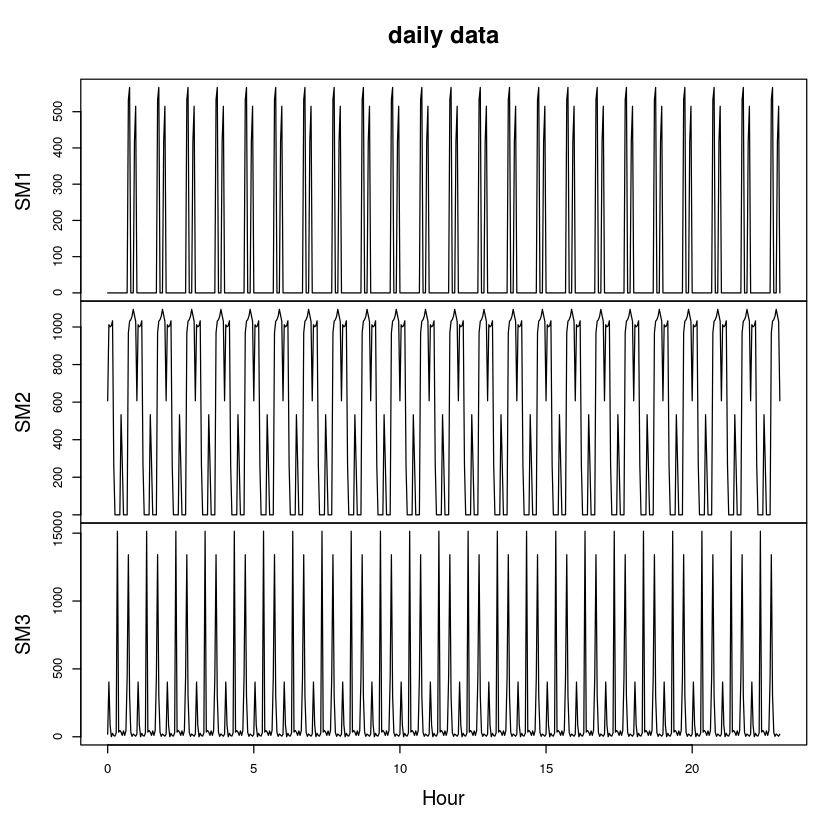

In [69]:
# view day one power consumption [Wh], by hour, faceted by submeter
plot(dayOne, xlab="Hour", ylab="Consumption [Wh]", main="daily data", type="l")